In [1]:
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *
## For data
import pandas as pd
import numpy as np
## For plotting
import matplotlib.pyplot as plt
## For parametric fitting
from scipy import optimize

In [2]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,964,969,981,989,998,1004,1029,1050,1076,1099
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,762,762,762,762,762,763,763,763,763,764
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,52,58,60,61,69,70,70,71,74,81


In [3]:
## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["China"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

In [4]:
dtf.tail()

,total,new
2020-05-25,84102,7.0
2020-05-26,84103,1.0
2020-05-27,84106,3.0
2020-05-28,84106,0.0
2020-05-29,84123,17.0


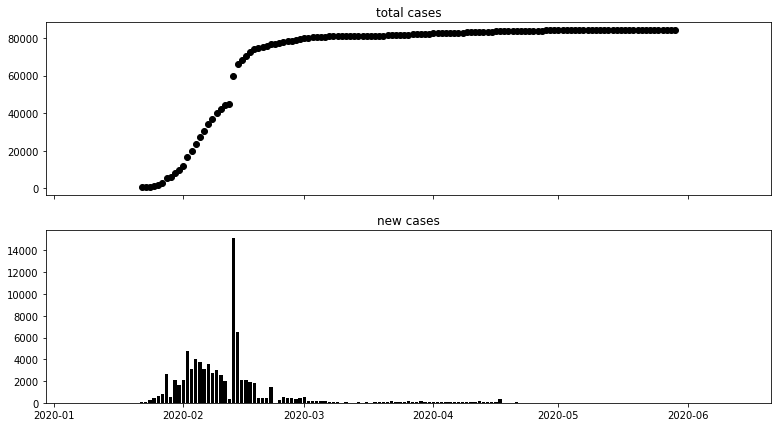

In [5]:

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="black")
ax[0].set(title="total cases")
ax[1].bar(dtf.index, dtf["new"].values, color="black")
ax[1].set(title="new cases")
plt.show()


In [6]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 10 + 1500*x

y_linear = f(x=np.arange(len(dtf)))

'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 10 + 1.1**x

y_exponential = f(x=np.arange(len(dtf)))


'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 90000 / (1 + np.exp(-0.5*(x-20)))

y_logistic = f(x=np.arange(len(dtf)))



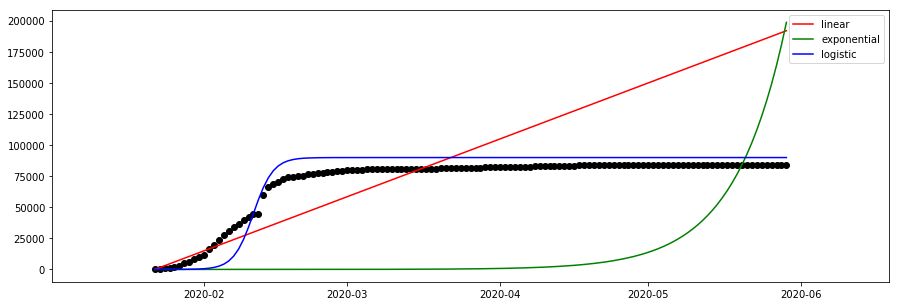

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [8]:
'''
Function to fit. In this case logistic function:
    f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

## Fit
model = fit_curve(X=np.arange(len(dtf["total"])), y=dtf["total"].values, f=f, p0=[np.max(dtf["total"]), 1, 1])
model

array([8.27687701e+04, 2.10866072e-01, 1.80681877e+01])

--- generating index date --> start: 2020-05-30 00:00:00 | end: 2020-07-07 00:00:00 | len: 39 ---


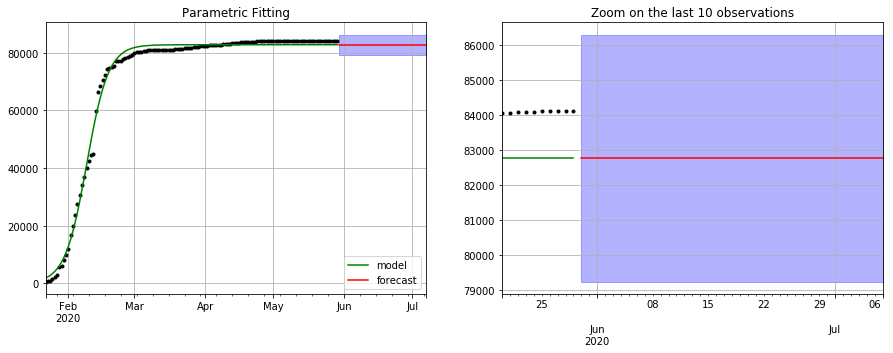

In [9]:
## Forecast
preds = forecast_curve(dtf["total"], f, model, pred_ahead=40, end=None, freq="D", zoom=10, figsize=(15,5))

In [10]:
'''
Function to fit. In this case gaussian function:
    f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

In [11]:
model = fit_curve(X=np.arange(len(dtf["new"])), y=dtf["new"].values, f=f, p0=[1, np.mean(dtf["new"]), np.std(dtf["new"])])
model

array([4261.4416016 ,   18.31634613,    7.54698501])

--- generating index date --> start: 2020-05-30 00:00:00 | end: 2020-06-27 00:00:00 | len: 29 ---


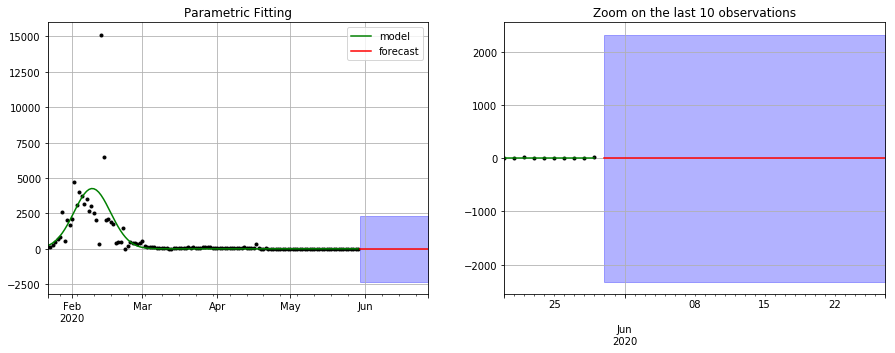

In [12]:
## Forecast
preds = forecast_curve(dtf["new"], f, model, pred_ahead=30, end=None, freq="D", zoom=10, figsize=(15,5))